## Jan 2018 ACT f2f hack day tutorial

This tutorial will introduce you to a few tools in `orphics`, which are essentially wrappers around software like CAMB and `enlib`. Let's start by importing a few necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
from orphics import io, maps, stats, cosmology
from enlib import enmap, resample
import numpy as np

We want to first define a geometry for our map, by obtaining a numpy array shape and a WCS from a physical geometry. We then create a `Cosmology` object, an interface to CAMB that lets us get CMB power spectra. We plot the TT spectrum.

Generating theory Cls...


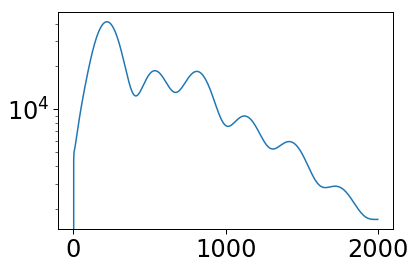

In [4]:
shape, wcs = maps.rect_geometry(width_deg = 5.0, px_res_arcmin = 0.5)
cc = cosmology.Cosmology(lmax=2000,pickling=True,dimensionless=False)
ells = np.arange(0,2000,1)
cltt = cc.theory.lCl('TT',ells)

pl = io.Plotter(yscale='log')
pl.add(ells,cltt*ells**2.)
pl.done()

In [ ]:
shape, wcs = maps.rect_geometry

We can now reshape the TT spectrum into an enlib polarization friendly form, and set up a gaussian random field generator for the specified geometry and power spectrum. We obtain two random maps from this and plot them.

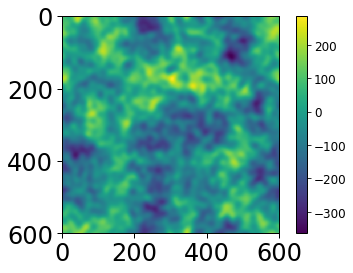

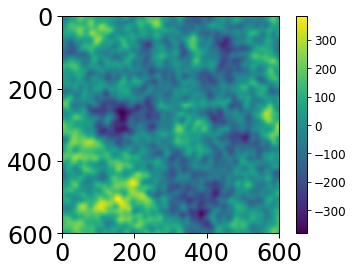

In [7]:
ps = cltt.reshape((1,1,ells.size))
generator = maps.MapGen(shape,wcs,ps)
random_map = generator.get_map()
random_map2 = generator.get_map()

io.plot_img(random_map)
io.plot_img(random_map2)

We next define a taper that we will apply to this map before we take its fourier transform. We make a 1 deg wide cosine taper. The `w2` factor will come in handy later.

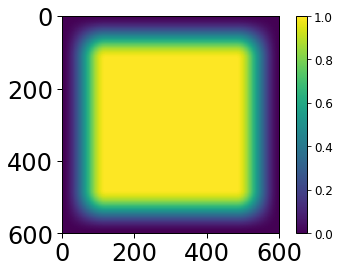

In [8]:
taper, w2 = maps.get_taper_deg(shape,wcs,taper_width_degrees=1.0)
io.plot_img(taper)

We can now multiply our maps by this taper and set up a power spectrum calculator object. We calculate the auto of the first map and the cross spectra of the first with the second. In doing the latter, we reuse the fourier transform calculated earlier to not waste time!

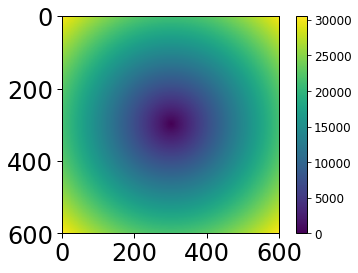

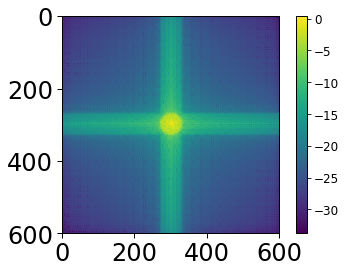

/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


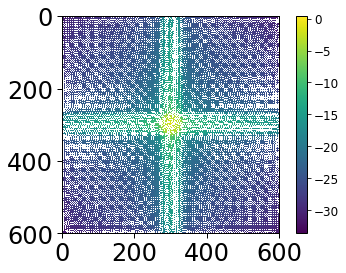

In [9]:
tapered_map = random_map * taper
tapered_map2 = random_map2 * taper
fc = maps.FourierCalc(shape,wcs)
auto_power, k1, _ = fc.power2d(tapered_map) # power from real map
cross_power, k2 = fc.f1power(tapered_map2,k1)  # power from real map and fourier map
modlmap = enmap.modlmap(shape,wcs)
io.plot_img(np.fft.fftshift(modlmap))
io.plot_img(np.fft.fftshift(np.log10(auto_power)))
io.plot_img(np.fft.fftshift(np.log10(cross_power)))


We need to bin these 2D power spectra into annuli. We define bin edges in 1D multipole space and create a binning object based on the absolute wavenumbers in the map. We then apply the binning object to the 2D powers and plot our results.

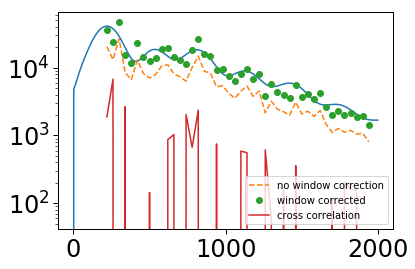

In [11]:
bin_edges = np.arange(200,2000,40)
binner = stats.bin2D(modlmap,bin_edges)
cents, a1d = binner.bin(auto_power)
cents, c1d = binner.bin(cross_power)

pl = io.Plotter(yscale='log')
pl.add(ells,cltt*ells**2.)
pl.add(cents,a1d*cents**2.,ls="--",label="no window correction")
pl.add(cents,a1d*cents**2./w2,marker="o",ls="none",label="window corrected")
pl.add(cents,c1d*cents**2.,label="cross correlation")
pl.legend(loc="lower right")
pl.done()